# Problem Statement - Using Pubmed article abstracts belonging to three categories - *Dermatology , Cancer and Gastrology* and their related journals, design models which could classify a pubmed article abstract into one of the given three categories.

Please note this colab was run in Google colab. 

I tried using RISE libary for slide presentation but it does not work in google colab.

Also, since i had issues unzipping these files from your shared location, I had to extract the given files in my drive  - https://drive.google.com/drive/folders/1rAG5Pw2yBj0YMNcm82rGMtNnu4kJFjCe?usp=sharing and accessed them using google drive api. This restricted link has view access to those who has this link.

Author - Nisha Mohan Devadiga

Mail - nishamohan.devadiga@sjsu.edu

# Instructions
Welcome to ProcDNA's case study round for NLP. This is a scenario where we try to
1. Provide you with a flavour of the things that you will work on at ProcDNA, and
2. Evaluate your skilset in this domain. 
Some elements of the problem statement may be deliberately obtuse - we work in very unstructured environments, and the ability to think of a solution on your feet in necessary for us to distinguish ourselves from our competition. We expect this case study to take at most *5* hours if you are familiar with basic NLP.

## Tasks for the NLP Case Study
1. Filter the dataset for the journals that belong to known *Specialty* `category`.
2. There are two files:
    1. PubMed article abstracts along with the journals they are from, and 
    2. A list of journals that belong to *Oncology*, *Dermatology* and *Gastroenterology* specialties (i.e. `category`).
2. Create *any* set of models (minimum 3) that is capable of categorizing a given abstract into the known categories. For example - you can use a text mining approach followed by building ML algorithms, a series of unsupervised methods that layer underneath supervised models, or completely base your answer on Deep Learning methods.
3. Evaluate these models - which one would you choose? Are there any specific tasks that are favoured for a specific model? What other tasks can you think of for these abstracts?

## Evaluation Criteria

### Documentation and coding quality

1. You may use Python or R. Please be as Pythonic as possible, and follow [style guides](https://google.github.io/styleguide/Rguide.html) where applicable.
2. In a startup, documentation is incredibly important - things change quickly, and someone else may need to take up your work, and should not be lost in your code.
3. You may also submit your R code as an RMarkdown document, or use a [slide based approach](https://rise.readthedocs.io/en/stable/) for Python. This is not critical, but a good-to-have.

### Model selection and pre-processing
1. The case study focuses less on data cleaning, but it is important to show clearly the steps that you used for getting the data in a model ready format.
2. The actual models you choose are not specified, and you may go as far as Deep Learning, but remember to tilt the trade-off between accuracy and speed of execution towards the latter.
3. In our start-up environment, we may need to come up with an MVP quickly first, and then code that goes into production later. Speed of analyses is more important.
4. Evaluation metrics are important - explain the various scenarios where a particular model may work better than another, and why.

## Install required libraries before running the colab.

In [1]:
!pip install transformers contractions RISE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

In [3]:
!pip install -q tf-models-official==2.7.0

# Section - 1 Machine Learning: Category Classification using sklearn and nltk techniques.


## Load necessary libraries


In [4]:
import os, sys
import pandas  as pd
import numpy   as np
from   pathlib  import Path
from google.colab import drive

team_folder ="CaseStudy"
drive.mount('/content/drive', force_remount=True)
shared_drive_team ="/content/drive/MyDrive/"+ team_folder

os.chdir(shared_drive_team)

Mounted at /content/drive


## Read input data files

In [5]:
if Path("data/abstracts.feather").exists():
    data = pd.read_feather("data/abstracts.feather").loc[lambda x: x.abstract != "NA", ["journal", "abstract"]]
else:
    data = pd.concat(map(pd.read_feather, Path("data/").glob("*.ftr")))
    data.reset_index(drop=True).to_feather("data/abstracts.feather")

In [6]:
data.head()

,journal,abstract
0,Sensors (Basel),This article aims at demonstrating the feasibi...
1,Sensors (Basel),"In the current education environment, learning..."
2,Sensors (Basel),A microwave photonics method has been develope...
3,Sensors (Basel),This study proposes a multiplexed weak waist-e...
4,Sensors (Basel),The COVID-19 pandemic has been the most critic...


Journals that belong to known categories

In [7]:
journal_files = [(x,y) for x,y in zip(Path("data/classification").glob("*.csv"), ["Derm", "Gastro", "Cancer"])]
journal_list  = pd.concat(map(lambda x: pd.read_csv(x[0]).assign(category=x[1]), journal_files))

Merge with original `data` DF:

In [8]:
data = data.merge(journal_list, on="journal") #.drop("journal", axis=1)

In [9]:
data['category'].unique()

array(['Gastro', 'Cancer', 'Derm'], dtype=object)

This concludes that we have extracted three specialization - Gastro , Cancer and Derm.

## Merge the Pubmed article files with the journal files.

In [10]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
# from nltk.stem import WordNetLemmatizer 
import re

# Stopwords
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stops = set(stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Merge the above data datset with pubmed article datasets on journal

In [11]:
df = [x for x in Path("data/").glob("*.ftr")]
pubmed_df  = pd.concat(map(lambda x: pd.read_feather(x),df))

In [12]:
pubmed_data = pubmed_df.merge(data, on="journal")
pubmed_data.head()

,pmid,doi,authors,year,articletitle,journal,volume,issue,affiliations,pages,abstract_x,meshHeadings,chemNames,grantAgency,grantNumber,grantCountry,nctID,ptype,abstract_y,category
0,34878801,10.1200/JCO.21.02677,Giordano Sharon H|Freedman Rachel A|Somerfield...,2021,Abemaciclib With Endocrine Therapy in the Trea...,J Clin Oncol,None,None,"MD Anderson Cancer Center, Houston, TX.|Dana-F...",JCO2102677,ASCO Rapid Recommendations Updates highlight r...,NA,NA,NA,NA,NA,NA,Journal Article,Definitive or postoperative chemoradiation (CR...,Cancer
1,34878801,10.1200/JCO.21.02677,Giordano Sharon H|Freedman Rachel A|Somerfield...,2021,Abemaciclib With Endocrine Therapy in the Trea...,J Clin Oncol,None,None,"MD Anderson Cancer Center, Houston, TX.|Dana-F...",JCO2102677,ASCO Rapid Recommendations Updates highlight r...,NA,NA,NA,NA,NA,NA,Journal Article,The Oncology Grand Rounds series is designed t...,Cancer
2,34878801,10.1200/JCO.21.02677,Giordano Sharon H|Freedman Rachel A|Somerfield...,2021,Abemaciclib With Endocrine Therapy in the Trea...,J Clin Oncol,None,None,"MD Anderson Cancer Center, Houston, TX.|Dana-F...",JCO2102677,ASCO Rapid Recommendations Updates highlight r...,NA,NA,NA,NA,NA,NA,Journal Article,We compared 2 years of rituximab maintenance (...,Cancer
3,34878801,10.1200/JCO.21.02677,Giordano Sharon H|Freedman Rachel A|Somerfield...,2021,Abemaciclib With Endocrine Therapy in the Trea...,J Clin Oncol,None,None,"MD Anderson Cancer Center, Houston, TX.|Dana-F...",JCO2102677,ASCO Rapid Recommendations Updates highlight r...,NA,NA,NA,NA,NA,NA,Journal Article,The CLL14 study has established one-year fixed...,Cancer
4,34878801,10.1200/JCO.21.02677,Giordano Sharon H|Freedman Rachel A|Somerfield...,2021,Abemaciclib With Endocrine Therapy in the Trea...,J Clin Oncol,None,None,"MD Anderson Cancer Center, Houston, TX.|Dana-F...",JCO2102677,ASCO Rapid Recommendations Updates highlight r...,NA,NA,NA,NA,NA,NA,Journal Article,To characterize the association between neuroc...,Cancer


In [13]:
pubmed_data['category'].unique()

array(['Cancer', 'Gastro', 'Derm'], dtype=object)

From the above result we can be sure that we are retrieving the abstracts only for required three specialities - Oncology, Dermatology and Gastrology.

In [14]:
final_data = pubmed_data.filter(items=['abstract_y','category']).drop_duplicates().reset_index(drop=True)
final_data.head()

,abstract_y,category
0,Definitive or postoperative chemoradiation (CR...,Cancer
1,The Oncology Grand Rounds series is designed t...,Cancer
2,We compared 2 years of rituximab maintenance (...,Cancer
3,The CLL14 study has established one-year fixed...,Cancer
4,To characterize the association between neuroc...,Cancer


In [15]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4689 entries, 0 to 4688
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   abstract_y  4689 non-null   object
 1   category    4689 non-null   object
dtypes: object(2)
memory usage: 73.4+ KB


In [16]:
final_data.abstract_y[0]

'Definitive or postoperative chemoradiation (CRT) is curative for human papillomavirus-associated (HPV+) oropharynx cancer (OPC) but induces significant toxicity. As a deintensification strategy, we studied primary transoral surgery (TOS) and reduced postoperative radiation therapy (RT) in intermediate-risk HPV+ OPC.|E3311 is a phase II randomized trial of reduced- or standard-dose postoperative RT for resected stage III-IVa (American Joint Committee on Cancer-seventh edition) HPV+ OPC, determined by pathologic parameters. Primary goals were feasibility of prospective multi-institutional study of TOS for HPV+ OPC, and oncologic efficacy (2-year progression-free survival) of TOS and adjuvant therapy in intermediate-risk patients after resection. TOS plus 50 Gy was considered promising if the lower limit of the exact 90% binomial confidence intervals exceeded 85%. Quality of life and swallowing were measured by functional assessment of cancer therapy-head and neck and MD Anderson Dysphag

In [17]:
final_data.shape

(4689, 2)

## Save the file in feather file and export it for training deep learning model in the next section.

In [18]:
os.chdir('/content')

filepath = Path('output/final.ftr')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
final_data.to_feather(filepath)  

## Data Visualization

In [19]:
import matplotlib.pyplot as plt

from sklearn.feature_extraction import text

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *
import plotly.figure_factory as ff
import seaborn as sns


%matplotlib inline

from wordcloud import WordCloud


add_stop_words = ['patients', 'group' ,'including' ,'compared' ,'using' , 'However','treatment','showed',
                  'study','associated','disease','data','observed','respectively','case','used','expression',
                  'performed','P','based','included']
new_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

### Create WordCloud for Cancer related Abstracts.

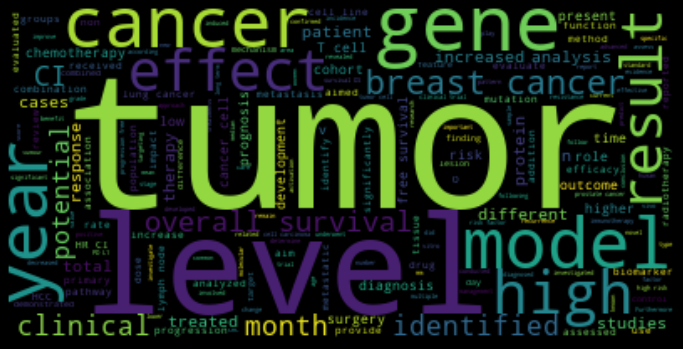

In [20]:
df_cancer = final_data[final_data['category'] == 'Cancer']

text_cancer = " ".join(review for review in df_cancer['abstract_y'])

wordcloud = WordCloud(stopwords=new_stop_words).generate(text_cancer)

plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_cancer.png')
plt.show()

From the above image, it is clear that most of common words that constitutes cancer related abstract has "tumor", "cancer", "gene", "breast", "protein" and many more.

### Create WordCloud for Derma related Abstracts.

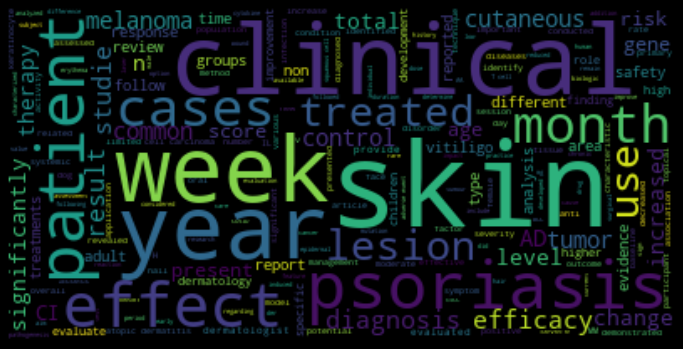

In [21]:
df_derm = final_data[final_data['category'] == 'Derm']

text_derm = " ".join(review for review in df_derm['abstract_y'])

wordcloud = WordCloud(stopwords=new_stop_words).generate(text_derm)

plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_derma.png')
plt.show()

From the above image, it is clear that most of common words that constitutes skin disease related abstract has "skin", "lesion", "psoriasis", "cutaneoustumor", "melanoma" and many more.

### Create WordCloud for Gastro-related Abstracts.

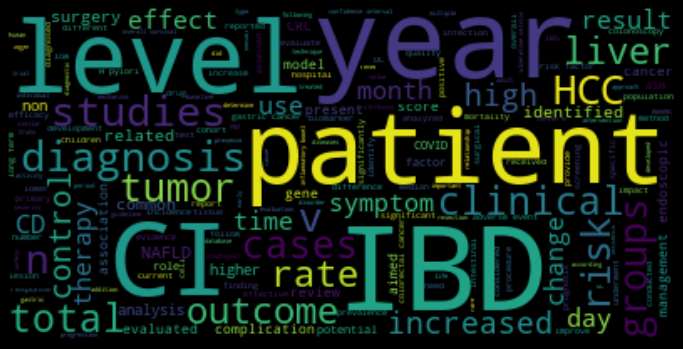

In [22]:
df_gastro = final_data[final_data['category'] == 'Gastro']

text_gastro = " ".join(review for review in df_gastro['abstract_y'])

wordcloud = WordCloud(stopwords=new_stop_words).generate(text_gastro)

plt.figure(figsize = (12, 12), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud_gastro.png')
plt.show()

From the above image, it is clear that most of common words that constitutes stomach disease related abstract has "HCC", "CI", "liver", "IBD", "NAFLD" and many more.

### Bar Diagram representing Pubmed articles related to each specialization.

In [23]:
category_order = list(final_data.category.unique())
category_order

['Cancer', 'Gastro', 'Derm']

In [24]:
fig = px.histogram(final_data, x='category', color="category", barmode='group')
fig.update_yaxes(title='No of Abstracts').update_xaxes(title='Specialization')
fig.show()

The above bar diagram shows the data distribution is uneven with majority of the articles related to oncology, followed by Gastro and then Derma. 

### Text Length Analysis

In [25]:
final_data['length_text'] = final_data.abstract_y.apply(len)

fig = px.box(final_data,
             x='category',
             y='length_text',
             color='category',
             category_orders={'category': category_order})
fig.update_yaxes(title='Text Length').update_xaxes(title='Specialization')
fig.show()

The above box plot shows the cancer has highest text length of 5806 words.

In [26]:
X = final_data.filter(items=['abstract_y'])
y = final_data.filter(items=['category'])

## Use Label Encoder to encode target labels into integers.

In [27]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

label = y
label_enc = LabelEncoder()
label = label.to_numpy().reshape(-1, 1)  # convert 1 dimensional array into 2D.
label = label_enc.fit_transform(label)
label.shape

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



(4689,)

In [28]:
label_names = label_enc.inverse_transform([[0],[1],[2]])
label_names

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



array(['Cancer', 'Derm', 'Gastro'], dtype=object)

## Pre-processing the text by cleaning.




Before I start modeling the textual data, I have used AutoTokenizer transformer from hugging face to clean and normalize the text.

In [29]:
from transformers import AutoTokenizer
import contractions

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer.backend_tokenizer))

<class 'tokenizers.Tokenizer'>


In [30]:
def normalize(text):
    # to remove accented letters
    text = tokenizer.backend_tokenizer.normalizer.normalize_str(text)
    text = contractions.fix(text)  
    text = text.strip().lower() 
    text = re.sub(r"'", ' ', text)  
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((i, " ") for i in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = ' '.join([w for w in text.split()])   
    # Replace multiple space with one space
    text = re.sub(' +', ' ', text)   
    pre_tokenize_result = ''.join(text)
    return pre_tokenize_result

X['abstract'] = X['abstract_y'].apply(normalize)
X.head()

,abstract_y,abstract
0,Definitive or postoperative chemoradiation (CR...,definitive or postoperative chemoradiation crt...
1,The Oncology Grand Rounds series is designed t...,the oncology grand rounds series is designed t...
2,We compared 2 years of rituximab maintenance (...,we compared 2 years of rituximab maintenance r...
3,The CLL14 study has established one-year fixed...,the cll14 study has established one year fixed...
4,To characterize the association between neuroc...,to characterize the association between neuroc...


In [31]:
X.drop(columns=['abstract_y'],inplace=True)
X.head()

,abstract
0,definitive or postoperative chemoradiation crt...
1,the oncology grand rounds series is designed t...
2,we compared 2 years of rituximab maintenance r...
3,the cll14 study has established one year fixed...
4,to characterize the association between neuroc...


## Removal of Stopwords

Use NLTK stopwords to remove the low-level information from our text in order to give more focus to the important information.

In [32]:
def stopword_removal(text):
    result = ""
    for word in text.split():
      if word not in stop_words:
        result  = result + ' ' + ''.join(word)
    return result

X['abstract'] = X['abstract'].apply(stopword_removal)
X.head()

,abstract
0,definitive postoperative chemoradiation crt c...
1,oncology grand rounds series designed place o...
2,compared 2 years rituximab maintenance rm res...
3,cll14 study established one year fixed durati...
4,characterize association neurocognitive outco...


## Lemmatization

Instead of stemming, I have used lemmatization because it   gives the dictionary meaning word while converting into root-form. 

Stemming, on the other hand, is used when the meaning of the word is not important for analysis. In our case, we needed the meaning of the word retained hence we choose lemmatization over stemming. Here I have considerred POS = Noun, Adjective, Verb and Adverb

In [33]:
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatization(text):
      allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
      texts_out = ""
      text = nlp("".join(text)) 
      for token in text:
        if token.pos_ in allowed_postags:
          lemma_result = token.lemma_           
          texts_out = texts_out + ' ' + lemma_result
      return texts_out

X['abstract'] = X['abstract'].apply(lemmatization)
X.head()

,abstract
0,definitive postoperative chemoradiation crt c...
1,oncology grand round series design place orig...
2,compare year rituximab maintenance response a...
3,cll14 study establish year fix duration treat...
4,memory processing speed radiation frontal whi...


## Split the data into train and test data set with split ratio = 0.4

Convert Array to List for both X and y dataset before splitting the dataset into train and test dataset.

In [40]:
X_list = list(X['abstract'])
y_arr = np.reshape(label , label.shape[0]) #y.shape[0] #4689
y_list = list(y_arr)

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_list, y_list, test_size = 0.4, random_state = 42)

##Build Pipeline using CountVectorizer , TfidfTransformer and Model.

Text preprocessing, tokenizing and filtering of stopwords are all included in CountVectorizer, which builds a dictionary of features and transforms texts into feature vectors.

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts

<2813x15623 sparse matrix of type '<class 'numpy.int64'>'
	with 223932 stored elements in Compressed Sparse Row format>

In [43]:
count_vect.vocabulary_.get(u'cancer')

1932

After vectorization, use TfidfTransformer to convert into a matrix of TF-IDF features.

***TF (term frequency)*** gives us information on how often a term appears in a document and ***IDF (inverse document frequency)*** gives us information about the relative rarity of a term in the collection of documents.

In [44]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(2813, 15623)

In [45]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2813, 15623)

Now the training dataset is ready for modeling using both unsupervised and supervised techniques.

In [46]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, y_train)

###**Unsupervised - Clustering model**

K-means is one of the simplest unsupervised learning algorithms that solve the well known clustering problem. So for our analysis, we will consider Kmeans++.

But before we processing unsupervised technique, lets find out the optimal clusters k using elbow method.

In [47]:
# checking for optimal number of clusters
from sklearn.cluster import KMeans


Plot the Elbow curve to identify the optimal clusters.

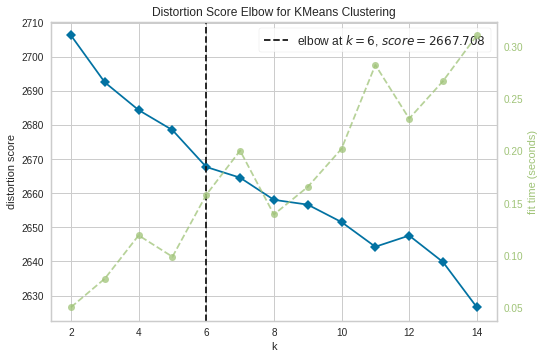

In [48]:
from yellowbrick.cluster import KElbowVisualizer
import os, warnings

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  km = KMeans( init='k-means++', max_iter=100, n_init=1)
  visualizer = KElbowVisualizer(km, k=(2,15))
  visualizer.fit(X_train_tfidf)        
  visualizer.show()  ;

**Optimal number of clusters is estimated to be 12**

In [49]:
from sklearn.cluster import KMeans

true_k = 12
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X_train_tfidf)

KMeans(max_iter=100, n_clusters=12, n_init=1)

In [50]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [51]:
for i in range(true_k):
  print('')
  print(10*'*')
  print(f'Cluster {i}:')
  print(10*'*')
  for ind in order_centroids[i, :10]:
    print(f'.      {terms[ind]}')


**********
Cluster 0:
**********
.      patient
.      ibd
.      care
.      covid
.      cancer
.      symptom
.      health
.      pandemic
.      disease
.      quality

**********
Cluster 1:
**********
.      resection
.      patient
.      surgical
.      tumor
.      surgery
.      treatment
.      pancreatic
.      recurrence
.      case
.      cancer

**********
Cluster 2:
**********
.      cell
.      expression
.      cancer
.      tumor
.      proliferation
.      target
.      protein
.      gene
.      signal
.      induce

**********
Cluster 3:
**********
.      liver
.      patient
.      radiomic
.      model
.      feature
.      risk
.      hcc
.      predict
.      cirrhosis
.      image

**********
Cluster 4:
**********
.      patient
.      skin
.      case
.      disease
.      treatment
.      study
.      use
.      lesion
.      report
.      diagnosis

**********
Cluster 5:
**********
.      radiotherapy
.      dose
.      toxicity
.      patient
.      gy
.

Now save the Model to file in the models/ml/unsupervised directory

In [52]:
import pickle
filepath = Path('models/ml/unsupervised/cluster_model.pkl')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
with open(filepath, 'wb') as file:  
    pickle.dump(model, file)

In [53]:
# Load the Model back from file
with open(filepath, 'rb') as file:  
    Pickled_Model = pickle.load(file)

Pickled_Model

KMeans(max_iter=100, n_clusters=12, n_init=1)

###**Supervised - Classification model**

We will use pipelines - Pipeline() to structure the NLP tasks - Count Vectorization, TF-IDF transformer and Classifier in a better way.. 

#### Classifier 1 - Gaussian naïve Bayes *classifier* provides a nice baseline for this task.

In [54]:
from sklearn.pipeline import Pipeline
text_mnb = Pipeline([
    ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [55]:
text_mnb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [56]:
predicted_mnb = text_mnb.predict(X_test)
np.mean(predicted_mnb == y_test)

0.656183368869936

In [57]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_mnb, target_names=['Cancer','Derm','Gastro']
   ))

              precision    recall  f1-score   support

      Cancer       0.65      1.00      0.79      1196
        Derm       0.50      0.00      0.01       273
      Gastro       0.97      0.09      0.16       407

    accuracy                           0.66      1876
   macro avg       0.71      0.36      0.32      1876
weighted avg       0.70      0.66      0.54      1876



In [58]:
metrics.confusion_matrix(y_test, predicted_mnb)

array([[1195,    0,    1],
       [ 272,    1,    0],
       [ 371,    1,   35]])

The above result shows that the accuracy of the Gaussian naïve Bayes classifier is 65%. we will try other classifiers and check whether they give better accuracy.

#### Classifier 2 - Stochastic Gradient Descent classifier provides a nice baseline for this task.


Gradient Descent is the most common optimization algorithm and the foundation of how we train an ML model.In this case, we use a variant of this algorithm known as Stochastic Gradient Descent to make our model learn a lot faster. 

In [59]:
from sklearn.linear_model import SGDClassifier

text_sgd = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', SGDClassifier(loss='hinge', penalty='l2',
                       alpha=1e-3, random_state=42,
                       max_iter=5, tol=None)),
])

In [60]:
text_sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [61]:
predicted_sgd = text_sgd.predict(X_test)
np.mean(predicted_sgd == y_test)

0.8646055437100213

In [62]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_sgd, target_names=['Cancer','Derm','Gastro']
   ))

              precision    recall  f1-score   support

      Cancer       0.84      0.98      0.91      1196
        Derm       0.95      0.72      0.82       273
      Gastro       0.94      0.61      0.74       407

    accuracy                           0.86      1876
   macro avg       0.91      0.77      0.82      1876
weighted avg       0.88      0.86      0.86      1876



In [63]:
metrics.confusion_matrix(y_test, predicted_sgd)

array([[1177,    7,   12],
       [  73,  197,    3],
       [ 155,    4,  248]])

The above result shows that the accuracy of the Gaussian naïve Bayes classifier is 86.46%. we will try our third classifier and check whether it gives better accuracy.

#### Classifier 3 - Support vector machine (SVM) classifier provides a nice baseline for this task.

In [64]:
from sklearn import svm

text_svm = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', svm.LinearSVC()),
])

In [65]:
text_svm.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [66]:
predicted_svm = text_svm.predict(X_test)
np.mean(predicted_svm == y_test)

0.8651385927505331

In [67]:
from sklearn import metrics
print(metrics.classification_report(y_test, predicted_svm, target_names=['Cancer','Derm','Gastro']
   ))

              precision    recall  f1-score   support

      Cancer       0.87      0.94      0.90      1196
        Derm       0.93      0.82      0.88       273
      Gastro       0.81      0.67      0.73       407

    accuracy                           0.87      1876
   macro avg       0.87      0.81      0.84      1876
weighted avg       0.86      0.87      0.86      1876



In [68]:
metrics.confusion_matrix(y_test, predicted_svm)

array([[1125,   10,   61],
       [  43,  225,    5],
       [ 128,    6,  273]])

The above result shows that the accuracy of the Gaussian naïve Bayes classifier is 86.46%. 

From the above models, it can be concluded that SVM gives better results compared to other classifier.

Save the best model and export it.

In [69]:
# Save the Model to file in the models/ml/supervised directory

filepath = Path('models/ml/supervised/bestclassfier_model.pkl')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
with open(filepath, 'wb') as file:  
    pickle.dump(text_svm, file)

In [70]:
# Load the Model back from file
with open(filepath, 'rb') as file:  
    Pickled_Model = pickle.load(file)

Pickled_Model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LinearSVC())])

In [71]:
import os
import shutil
import pandas as pd
import tensorflow as tf
import tensorflow_text as text

tf.get_logger().setLevel('ERROR')

# Section - 2: Deep Learning: Category Classification using Embedding and Tensorflow.

Human sentences are composed of words and phrases with a certain structure. Deep learning, especially recurrent neural models, is able to capture the sequence information in a much better sense.


One of the most important advantages of deep learning for NLP tasks is that Deep learning learns multiple levels of representation. This learned information is constructed level-by-level through compositionand this lower level of representation often can be shared across tasks.

In [72]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vector_size = 300
vocab_size = 15000
max_seq_len = 256

### Playing Defense by reading the abstracts file which was earlier saved in the output folder.

In [73]:
final_data = pd.read_feather('output/final.ftr')
print(f'The shape of dataset is : ({final_data.shape})')
final_data.head()

The shape of dataset is : ((4689, 2))


,abstract_y,category
0,Definitive or postoperative chemoradiation (CR...,Cancer
1,The Oncology Grand Rounds series is designed t...,Cancer
2,We compared 2 years of rituximab maintenance (...,Cancer
3,The CLL14 study has established one-year fixed...,Cancer
4,To characterize the association between neuroc...,Cancer


In [74]:
final_data = final_data.sample(frac=1, random_state=1).reset_index()

split_ratio = 0.3
train_nums = int(final_data.shape[0] * (1 - split_ratio))

train_data = final_data[:train_nums]
print(f'The shape of training data : {train_data.shape}')
print('----------------------------------------------------')
test_data = final_data[train_nums:]
print(f'The shape of test data : {test_data.shape}')

The shape of training data : (3282, 3)
----------------------------------------------------
The shape of test data : (1407, 3)


In [75]:
# Train Data Labels
train_data['category'] = train_data['category'].astype("category")
train_data['category_label'] = train_data['category'].cat.codes
train_features, train_labels = train_data['abstract_y'], tf.one_hot(train_data['category_label'], 3)

In [76]:
train_data.head()

,index,abstract_y,category,category_label
0,4662,"Approximately, 10% to 15% of patients in the U...",Gastro,2
1,4096,The intestinal microbiota is thought to be inv...,Gastro,2
2,1815,Pancreatic metastases (PM) from renal cell car...,Cancer,0
3,1550,To optimise the interleukin (IL)-31-blocking t...,Derm,1
4,2925,A number of studies have revealed the associat...,Gastro,2


In [77]:
# Test Data Labels
test_data['category'] = test_data['category'].astype("category")
test_data['category_label'] = test_data['category'].cat.codes
test_features, test_labels = test_data['abstract_y'], tf.one_hot(test_data['category_label'], 3)

I have used Keras tokenizer to convert tokens into integers, using <OOV> to represent Out of Vocabulary (OoV) terms. This is a significant advantage over the word2ve model since this is a flexible way of handling unseen vocabulary in test data.

In [78]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=vocab_size)
tokenizer.fit_on_texts(train_data['abstract_y'])

And, then convert use texts_to_sequences method to convert tokens of text corpus into a sequence of integers.

In [79]:
sequences_train = tokenizer.texts_to_sequences(train_data['abstract_y'])
sequences_test = tokenizer.texts_to_sequences(test_data['abstract_y'])

Standardize Sequence Length as Selected Earlier

In [80]:
padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_seq_len)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_seq_len)

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [81]:
def build_classifier_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size, # keeping it same as the word2vec embedding size
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(max_seq_len,return_sequences=True))
    model.add(LSTM(3))
    model.add(Dense(3,activation='softmax'))
    return model

In [82]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=1,
                                  mode="min",
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/classifier_model.hdf5',
                                    verbose=1,
                                    save_best_only=True)
]

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

In [83]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 300)          4500000   
                                                                 
 dropout (Dropout)           (None, 256, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 256, 256)          570368    
                                                                 
 lstm_1 (LSTM)               (None, 3)                 3120      
                                                                 
 dense (Dense)               (None, 3)                 12        
                                                                 
Total params: 5,073,500
Trainable params: 5,073,500
Non-trainable params: 0
_________________________________________________________________


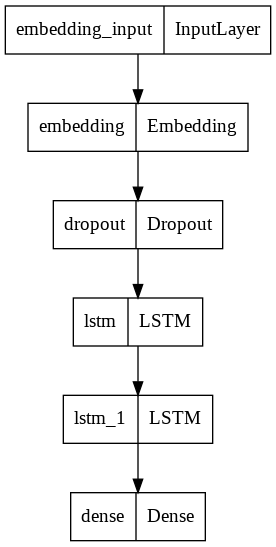

In [84]:
tf.keras.utils.plot_model(classifier_model)

### Loss function

Since this is a multi label classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.categorical_crossentropy` loss function.


### Optimizer

For fine-tuning, let's use the optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments)


### Loading the embedding model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [85]:
classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [86]:
tf.data.experimental.enable_debug_mode()

tf.config.run_functions_eagerly(True)
history = classifier_model.fit(padded_train,
                           train_labels,
                           validation_split=0.33,
                           callbacks=callbacks,
                           epochs=10)

Epoch 1/10
69/69 [==============================] - ETA: 0s - loss: 0.9396 - accuracy: 0.6206
Epoch 1: val_loss improved from inf to 0.92673, saving model to models/classifier_model.hdf5
69/69 [==============================] - 11s 92ms/step - loss: 0.9396 - accuracy: 0.6206 - val_loss: 0.9267 - val_accuracy: 0.6190
Epoch 2/10
69/69 [==============================] - ETA: 0s - loss: 0.9044 - accuracy: 0.6292
Epoch 2: val_loss improved from 0.92673 to 0.92563, saving model to models/classifier_model.hdf5
69/69 [==============================] - 6s 91ms/step - loss: 0.9044 - accuracy: 0.6292 - val_loss: 0.9256 - val_accuracy: 0.6199
Epoch 3/10
69/69 [==============================] - ETA: 0s - loss: 0.8906 - accuracy: 0.6292
Epoch 3: val_loss did not improve from 0.92563
69/69 [==============================] - 6s 84ms/step - loss: 0.8906 - accuracy: 0.6292 - val_loss: 0.9406 - val_accuracy: 0.6199
Epoch 4/10
69/69 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.6

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


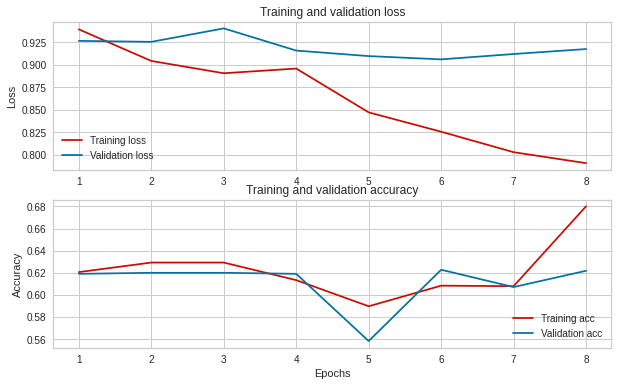

In [87]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

In [88]:
classifier_model = keras.models.load_model('models/classifier_model.hdf5')

In [89]:
y_pred_one_hot_encoded = (classifier_model.predict(padded_train)> 0.5).astype("int32")

In [90]:
y_pred_train = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

In [91]:
y_pred_one_hot_encoded = (classifier_model.predict(padded_test)> 0.5).astype("int32")
y_pred_test = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))

In [92]:
y_pred_test

array([0, 0, 0, ..., 0, 0, 0])

In [93]:
from sklearn.metrics import classification_report

with warnings.catch_warnings():
  warnings.filterwarnings("ignore")
  # Training set
  print(classification_report(train_data['category_label'], y_pred_train))
  # Test Set
  print(classification_report(test_data['category_label'], y_pred_test))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77      2054
           1       0.00      0.00      0.00       483
           2       0.00      0.00      0.00       745

    accuracy                           0.63      3282
   macro avg       0.21      0.33      0.26      3282
weighted avg       0.39      0.63      0.48      3282

              precision    recall  f1-score   support

           0       0.66      1.00      0.80       929
           1       0.00      0.00      0.00       171
           2       0.00      0.00      0.00       307

    accuracy                           0.66      1407
   macro avg       0.22      0.33      0.27      1407
weighted avg       0.44      0.66      0.53      1407



From the above classification report, we can notice that f1 score, precision and recall for 1 - Derma and 2 - Gastro is zero. This model needs fine-tuning to get a better accuracy , f1 score, precision and recall.